# Neural Net Game of Life

A grid of cells, each one has an hp value as a float between 0 and 1, and a color RGB.
each turn, the cell picks a color for itself, and tries to predict the color of all of its neighbors
cell gains hp based on how accurately it predicted neighbors colors
cell loses hp if neighbors predicted its color
a successful color prediction is a "chomp"

it needs memory! use a recursive network. need to use multiclass cross entropy loss function for learning.

cell takes more damage if a high hp cell chomps it?

cells with super high fitness copy their weights over to another cell?

LEARNING RATE tied to HP!!!

hostile environment? all cells take damage over time unless they act correctly to survive?

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import random

import torch
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np

In [4]:
color_strings = {
    0: "red",
    1: "green",
    2: "blue",
    3: "grey",
}
color_hexs = {
    0: [0xFF, 0x00, 0x00],
    1: [0x00, 0xFF, 0x00],
    2: [0x00, 0x00, 0xFF],
    3: [0x88, 0x88, 0x88],
}
color_one_hots = {
    0: [1, 0, 0],
    1: [0, 1, 0],
    2: [0, 0, 1]
}

class Cell():
    def __init__(self, hidden_layers = 1, hidden_size = 16, activation = nn.ReLU):
        self.hp = 50
        self.color = random.randint(0, 2)
        self.next_throw = self.color
        self.neighbors = []
        self.brain = nn.Sequential(
            nn.Linear(15, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 3),
        )
        self.optimizer = optim.SGD(self.brain.parameters(), lr=0.01)
        self.loss = nn.L1Loss()
        self.choice_dist = torch.tensor([0.333, 0.333, 0.333], dtype=torch.float, requires_grad=True)

    def make_choice(self, sense_data):
        # use the neural net to choose what color to throw next turn
        vect_sense = torch.reshape(sense_data, (-1,))
        self.choice_dist = self.brain(vect_sense)
        choice_color_num = torch.argmax(self.choice_dist)
        self.next_throw = choice_color_num
        return self.choice_dist
    def learn(self, score_tensor, optimal_throw_tensor):
        # calculate gradients for parameters based on loss
        actual_score = score_tensor
        optimal_score = self.evaluate(optimal_throw_tensor)
        self.loss_object = self.loss(actual_score, optimal_score)
        self.loss_object.backward()
    def update(self):
        # alter weights and biases of neural net
        self.optimizer.step()
        self.optimizer.zero_grad()
    def evaluate(self, my_color_one_hot = None, sense_data = None):
        num_red_neighbors = 0
        num_green_neighbors = 0
        num_blue_neighbors = 0
        for neighbor in self.neighbors:
            if neighbor.color == 0:
                num_red_neighbors += 1
            if neighbor.color == 1:
                num_green_neighbors += 1
            if neighbor.color == 2:
                num_blue_neighbors += 1
        if my_color_one_hot is None:
            self_is_red, self_is_green, self_is_blue = self.color_one_hot()
        else:
            self_is_red, self_is_green, self_is_blue = my_color_one_hot
        wins = (self_is_red * num_green_neighbors) + (self_is_green * num_blue_neighbors) + (self_is_blue * num_red_neighbors)
        # consider different values for different kinds of wins, some choices are high risk high reward, others are low risk low reward.
        defeats = (self_is_red * num_blue_neighbors) + (self_is_green * num_red_neighbors) + (self_is_blue * num_green_neighbors)
        score = wins - defeats
        return score
    def optimal_play(self, sense_data):
        # determine what would have been the best color to throw this turn
        num_red_neighbors = 0
        num_green_neighbors = 0
        num_blue_neighbors = 0
        for neighbor in self.neighbors:
            if neighbor.color == 0:
                num_red_neighbors += 1
            if neighbor.color == 1:
                num_green_neighbors += 1
            if neighbor.color == 2:
                num_blue_neighbors += 1
        best_throw_num = np.argmax([num_green_neighbors, num_blue_neighbors, num_red_neighbors])
        best_throw_one_hot = color_one_hots[best_throw_num]
        return best_throw_one_hot
    def change_hp(self, hp_bonus):
        self.hp += hp_bonus
    def set_color(self, color_num):
        self.color = int(color_num)
    def get_color(self):
        color_array = np.array(self.color_one_hot())
        return color_array * int(self.hp / 100 * 255)
    def color_one_hot(self):
        return color_one_hots[self.color]
    def get_lr(self):
        # don't use yet, just a random idea i might use later
        return math.cos((math.pi / 2) * self.hp)
    def __repr__(self):
        return f" {color_strings[self.color]} Hp:{self.hp:.2f} "
        # print the state of the cell
    def sense(self):
        sense_data_list = [self.color_one_hot()]
        for neighbor in self.neighbors:
            sense_data_list.append(neighbor.color_one_hot())
        # sense data list is [self_color, north_neighbor, south_neighbor, west_neighbor, east_neighbor]
        sense_tensor = torch.tensor(sense_data_list, dtype=torch.float, requires_grad=True)
        return sense_tensor

        #fill an array with all the numerical values associated with everything the cell can see



In [5]:
class Board():
    def __init__(self, rows, cols):
        self.cells = []
        self.rows = rows
        self.cols = cols
        for row in range(rows):
            new_row = []
            for col in range(cols):
                new_row.append(Cell())
            self.cells.append(new_row)
        #Assign neighbors
        for row in range(rows):
            for col in range(cols):
                if self.rows > 1:
                    if row == 0:
                        self.cells[row][col].neighbors.append(self.cells[self.rows - 1][col])
                        self.cells[row][col].neighbors.append(self.cells[row + 1][col])
                    if (row > 0) and (row < self.rows - 1):
                        self.cells[row][col].neighbors.append(self.cells[row - 1][col])
                        self.cells[row][col].neighbors.append(self.cells[row + 1][col])
                    if row == self.rows - 1:
                        self.cells[row][col].neighbors.append(self.cells[row - 1][col])
                        self.cells[row][col].neighbors.append(self.cells[0][col])
                if self.cols > 1:
                    if col == 0:
                        self.cells[row][col].neighbors.append(self.cells[row][self.cols - 1])
                        self.cells[row][col].neighbors.append(self.cells[row][col + 1])
                    if (col > 0) and (col < self.cols - 1):
                        self.cells[row][col].neighbors.append(self.cells[row][col - 1])
                        self.cells[row][col].neighbors.append(self.cells[row][col + 1])
                    if col == self.cols - 1:
                        self.cells[row][col].neighbors.append(self.cells[row][col - 1])
                        self.cells[row][col].neighbors.append(self.cells[row][0])
    def __repr__(self):
        board_string = ''
        for row in self.cells:
            for cell in row:
                board_string += str(cell)
                board_string += ', '
            board_string += '\n'
        return board_string
    def show_img(self):
        img_list = []
        for row in range(0, self.rows):
            img_list.append([])
            for column in range(0, self.cols):
                img_list[row].append([])
                img_list[row][column] = (self.cells[row][column].get_color())
        img_array = np.array(img_list)
        plt.imshow(img_array)
        plt.show()
    def step(self):
        # all cells throw the color that they picked for this step
        for row in self.cells:
            for cell in row:
                cell.set_color(cell.next_throw)
        # all cells sense states of their neighbors and their own states
        for row in self.cells:
            for cell in row:
                sense_dat = cell.sense()
                hp_bonus = cell.evaluate(sense_data=None)
                cell.change_hp(hp_bonus)
                score_tensor = torch.tensor(hp_bonus, dtype=torch.float, requires_grad=True)
                best_throw_tensor = torch.tensor(cell.optimal_play(sense_data=None), dtype=torch.float)
                cell.learn(score_tensor, best_throw_tensor)
                cell.update()
                cell.make_choice(sense_data=sense_dat)
        # hp bonuses are calculated and added to hp
        # for each cell, determine what would have been the optimal play and the score that would've gotten
        # for each cell, calculate the loss from actual hp bonus and ideal hp bonus
        # for each cell, backward pass the loss gradient and then update weights in their neural net
        # all cells pick a color to throw on the next step from a forward pass in their net
        pass
    def time(self, num_steps):
        for i in range(num_steps):
            self.step()


In [6]:
first_board = Board(5, 5)




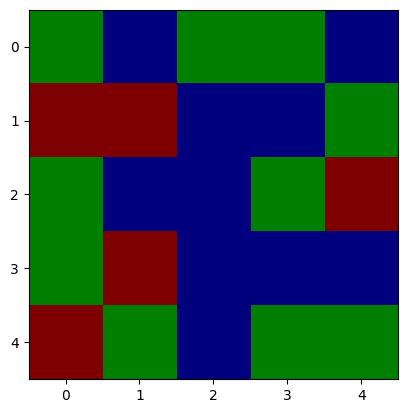

In [7]:
first_board.show_img()

In [8]:
first_board.step()

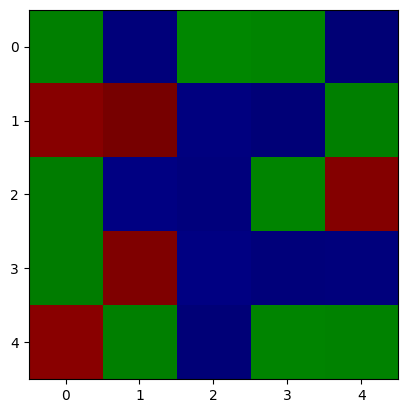

In [9]:
first_board.show_img()

In [16]:
first_board.time(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-379..731].


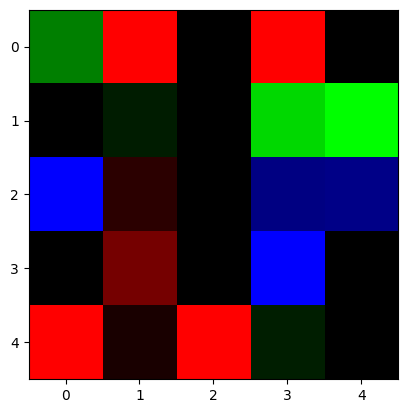

In [17]:
first_board.show_img()

In [ ]:
first_board.cells[2][2].evaluate()